In [43]:
# ====================
# To check and see if using tauuo/vo (which are on the ocean grid) is okay for
# estimating wind speed (which is on the atmosphere grid)
# ====================


# ====================
## Answer: Can't be done because the drag coefficient is not a constant: https://www.nemo-ocean.eu/doc/node70.html
# ====================


In [65]:
import netCDF4
import os
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import numpy as np
import scipy.interpolate.ndgriddata as ndgriddata

%matplotlib inline

In [66]:
ocean_data_dir = '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/tauuo/gn/latest'
taufile = os.path.join(ocean_data_dir, 'tauuo_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_185001-234912.nc')

atmos_data_dir = '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/uas/gr/latest'
uasfile = os.path.join(atmos_data_dir, 'uas_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc')

In [67]:
nt = 60

loaded = netCDF4.Dataset(taufile)
tauuo = loaded.variables['tauuo'][0:nt, :-1, 1:-1]
nav_lon = loaded.variables['nav_lon'][:-1, 1:-1]
nav_lat = loaded.variables['nav_lat'][:-1, 1:-1]

loaded2 = netCDF4.Dataset(uasfile)
uas = loaded2.variables['uas'][0:nt, :, :]
lon = loaded2.variables['lon'][:]
lat = loaded2.variables['lat'][:]

In [68]:
print(nav_lon.shape)

(331, 360)


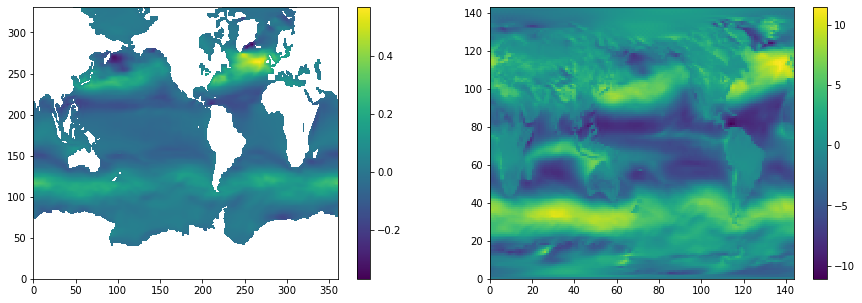

In [69]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.pcolormesh(tauuo[0, :, :])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.pcolormesh(uas[0, :, :])
plt.colorbar()

In [70]:
print(nav_lon.shape, nav_lat.shape, uas_from_tauuo.shape, lon.shape, lat.shape)

(331, 360) (331, 360) (60, 331, 360) (144,) (143,)


In [75]:
density = 1.2  # kg/m3
drag = 0.0015  # dimensionless

# kg / m / s2 / (kg / m3) == m2 / s2 -> m/s QED

uas_from_tauuo = np.sign(tauuo) * np.sqrt(abs(tauuo / (density * drag)))

ni = len(lon)
nj = len(lat)
lon_shifted = lon.copy()
lon_shifted[lon_shifted >= 180] -= 360
lon2d = np.repeat(lon_shifted[np.newaxis, :], nj, axis=0)
lat2d = np.repeat(lat[:, None], ni, axis=1)

uas_from_tauuo_regridded = np.ma.masked_all(shape=uas.shape)
for tt in range(nt):
    print(tt)
#     if tt > 3: continue
    fld_regridded = ndgriddata.griddata((nav_lon.flatten(), nav_lat.flatten()),
                                        uas_from_tauuo[tt, :, :].flatten(), (lon2d, lat2d), method="linear")
    if tt == 0:
        mask_regridded = ndgriddata.griddata((nav_lon.flatten(), nav_lat.flatten()),
                                             uas_from_tauuo[0, :, :].mask.flatten(),
                                             (lon2d, lat2d), method="linear")

    uas_from_tauuo_regridded[tt, :, :] = np.ma.array(fld_regridded, mask=mask_regridded)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [77]:
diff = uas_from_tauuo_regridded - uas

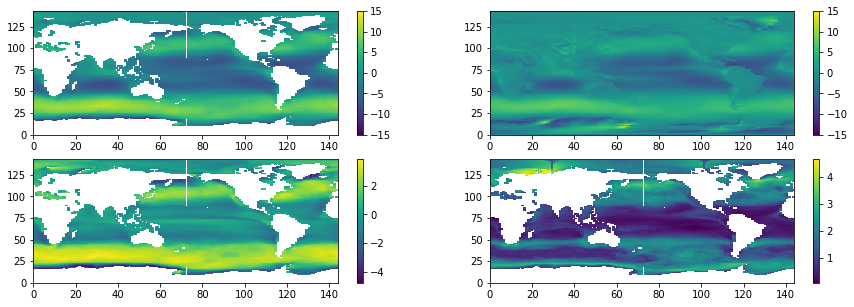

In [78]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 2, 1)
plt.pcolormesh(uas_from_tauuo_regridded.mean(axis=0), vmin=-15, vmax=15)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.pcolormesh(uas.mean(axis=0), vmin=-15, vmax=15)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.pcolormesh(diff.mean(axis=0))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.pcolormesh(diff.std(axis=0))
plt.colorbar()

Text(0, 0.5, 'Atmos')

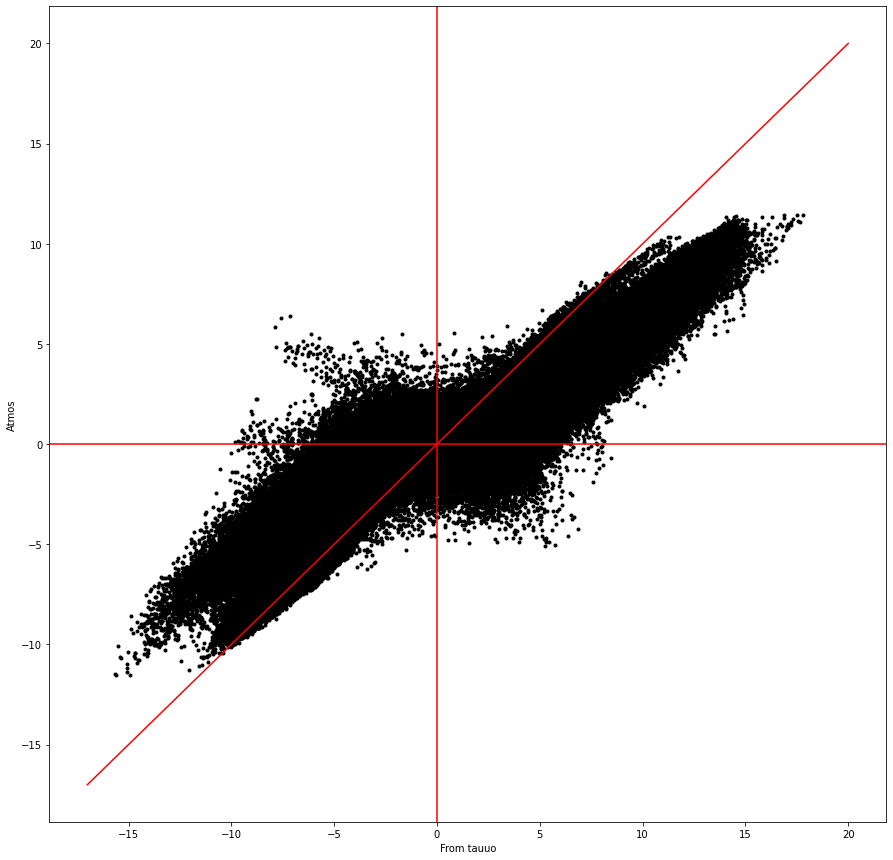

In [82]:
common_mask = np.ma.array(uas_from_tauuo_regridded, mask=uas.mask).mask

# uas_from_tauuo_regridded_common = np.ma.array(uas_from_tauuo_regridded, mask=common_mask)
# uas_common = np.ma.array(uas, mask=common_mask)
# plt.plot(uas_from_tauuo_regridded_common[~common_mask].flatten(), uas_common[~common_mask].flatten(), 'x')

xlim = np.array((-17, 20))
plt.figure(figsize=(15, 15))
plt.plot(uas_from_tauuo_regridded[~common_mask].flatten(), uas[~common_mask].flatten(), '.', color='k')
plt.axvline(0, color='red')
plt.axhline(0, color='red')
plt.plot(xlim, xlim, color='red')
plt.xlabel('From tauuo')
plt.ylabel('Atmos')